In [1]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from Methods import load_images, plot_sample_images, plot_model_metrics, plot_images_with_predictions, plot_confusion_matrix, plot_mismatched_images

### Model with noise
This is our second iteration of our model, using images in full context. Meaning the images contain the in-game background, directional lighting and might contain other objects from our 5 classes in the image.

By providing the model with more information and more complex images, the goal is to make it less likely to be biased, and better at accurately predicting the images gathered from live play.

In [3]:
image_dir = os.path.dirname(os.getcwd())+"\\Screenshots\\InContextInitial\\"
data = load_images(image_dir)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1440 non-null   int64 
 1   filename  1440 non-null   object
 2   label     1440 non-null   object
 3   img       1440 non-null   object
dtypes: int64(1), object(3)
memory usage: 45.1+ KB


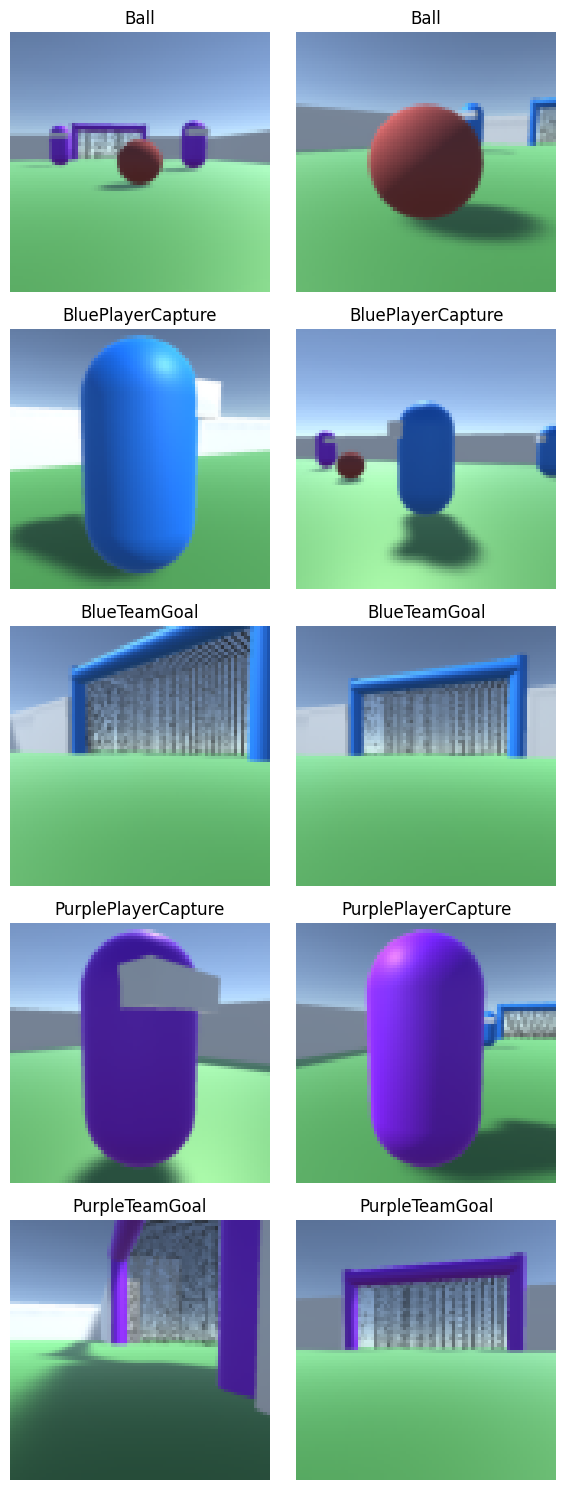

In [4]:
plot_sample_images(data)

In [5]:
#Splitting the data into training and testing
train_df, test_df = train_test_split(data, test_size=0.3)

# Datagen for training data. Augment the data by rotating, shifting, flipping, to make the model more robust and less prone to overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
    directory=image_dir,
    target_size=(64, 64),
    x_col='filename',
    y_col='label',
    batch_size=64,
    class_mode='categorical'
)



Found 1008 validated image filenames belonging to 5 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=64,
    class_mode= "categorical",
    shuffle=False
)

Found 432 validated image filenames belonging to 5 classes.


### Initial model

Working with more complex images than in our model without noise, we start by training a slightly more complex initial model. 

We've added two more layers and a higher amount of neurons in each layer.

As a starting point, the learning rate has been left at the default of 0.001.

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_initial = model.fit(train_generator,validation_data = test_generator, epochs=30)

C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.2868 - loss: 1.9904 - val_accuracy: 0.8009 - val_loss: 0.7283
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7447 - loss: 0.7826 - val_accuracy: 0.8495 - val_loss: 0.4178
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8729 - loss: 0.3925 - val_accuracy: 0.8310 - val_loss: 0.4305
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9110 - loss: 0.3053 - val_accuracy: 0.8681 - val_loss: 0.5420
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9398 - loss: 0.1652 - val_accuracy: 0.9051 - val_loss: 0.3274
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9517 - loss: 0.1430 - val_accuracy: 0.8889 - val_loss: 0.3171
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9660 - loss: 0.1333 - val_accuracy: 0.9074 - val_loss: 0.4736
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9813 - loss: 0.0805 - val_accuracy: 0.9074 - val_

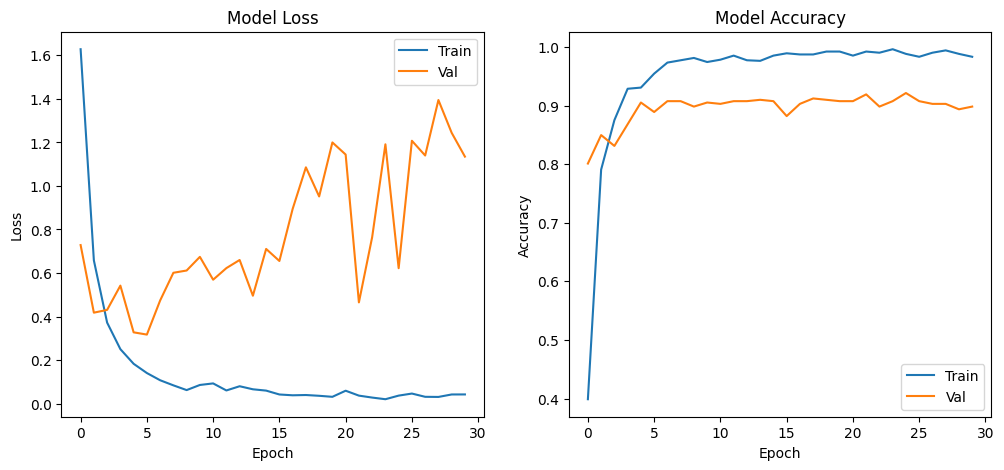

In [8]:
plot_model_metrics(trained_model_initial)

### Reducing learning rate

From our initial training we see the model converging almost immediately, which might lead to poor generalization. The model also shows clear signs of overfitting, by for example the big disparity between the validation and training accuracy/loss.

By lowering the learning rate, the updates to the model's parameters will be smaller and more controlled, which might help to mitigate overfitting and stabilize the training.

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_reduced_lr = model.fit(train_generator,validation_data = test_generator, epochs=30)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.2060 - loss: 1.6443 - val_accuracy: 0.5023 - val_loss: 1.4314
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.4382 - loss: 1.4538 - val_accuracy: 0.8264 - val_loss: 1.1142
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5816 - loss: 1.2540 - val_accuracy: 0.7569 - val_loss: 0.9452
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6266 - loss: 1.0701 - val_accuracy: 0.8056 - val_loss: 0.7547
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6421 - loss: 0.9298 - val_accuracy: 0.7847 - val_loss: 0.6667
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7186 - loss: 0.8377 - val_accuracy: 0.7060 - val_loss: 0.5969
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6931 - loss: 0.7565 - val_accuracy: 0.7824 - val_loss: 0.5994
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7682 - loss: 0.6883 - val_accuracy: 0.

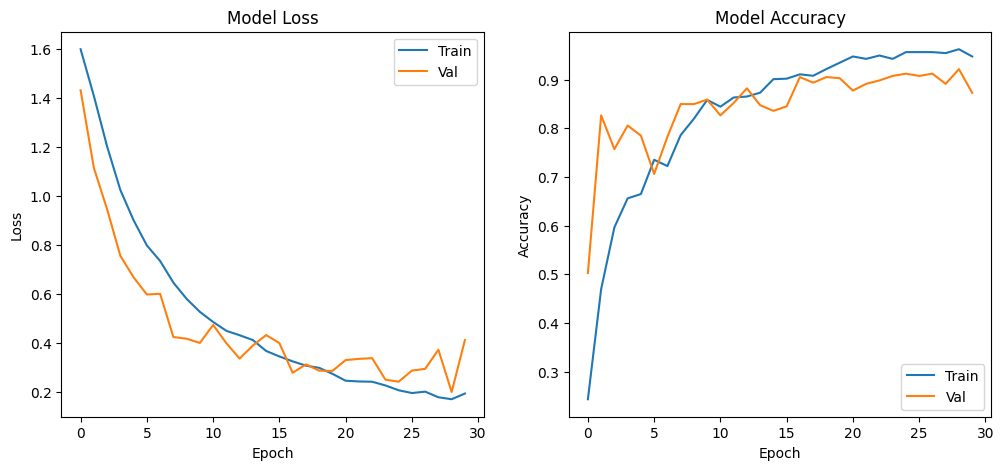

In [10]:
plot_model_metrics(trained_model_reduced_lr)

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_inc_epochs = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.2693 - loss: 1.5882 - val_accuracy: 0.3935 - val_loss: 1.3354
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.4137 - loss: 1.3269 - val_accuracy: 0.7940 - val_loss: 0.9887
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6195 - loss: 1.0863 - val_accuracy: 0.7176 - val_loss: 0.8596
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6540 - loss: 0.9268 - val_accuracy: 0.8056 - val_loss: 0.7213
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7154 - loss: 0.8294 - val_accuracy: 0.8102 - val_loss: 0.5606
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7432 - loss: 0.7348 - val_accuracy: 0.8657 - val_loss: 0.5103
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8119 - loss: 0.6208 - val_accuracy: 0.7870 - val_loss: 0.5996
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8095 - loss: 0.5634 - val_accuracy: 0.

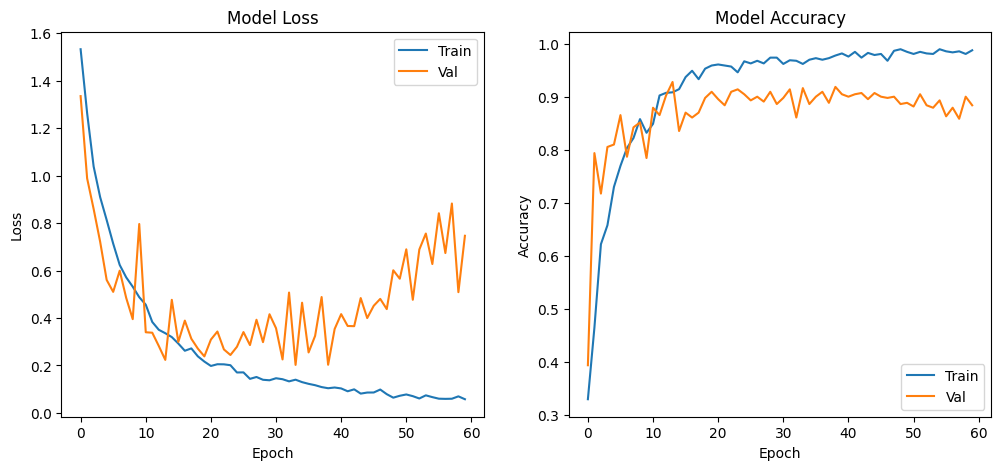

In [12]:
plot_model_metrics(trained_model_inc_epochs)

In [19]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_dropout = model.fit(train_generator,validation_data = test_generator, epochs=60)

C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.2540 - loss: 1.6750 - val_accuracy: 0.4329 - val_loss: 1.5198
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.3150 - loss: 1.5141 - val_accuracy: 0.5995 - val_loss: 1.3775
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.4398 - loss: 1.3850 - val_accuracy: 0.7176 - val_loss: 1.1784
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5344 - loss: 1.2250 - val_accuracy: 0.8333 - val_loss: 0.9817
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5552 - loss: 1.1184 - val_accuracy: 0.8125 - val_loss: 0.8397
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.6069 - loss: 0.9963 - val_accuracy: 0.9097 - val_loss: 0.7176
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6729 - loss: 0.8782 - val_accuracy: 0.9028 - val_loss: 0.6268
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7371 - loss: 0.8019 - val_accuracy: 0.

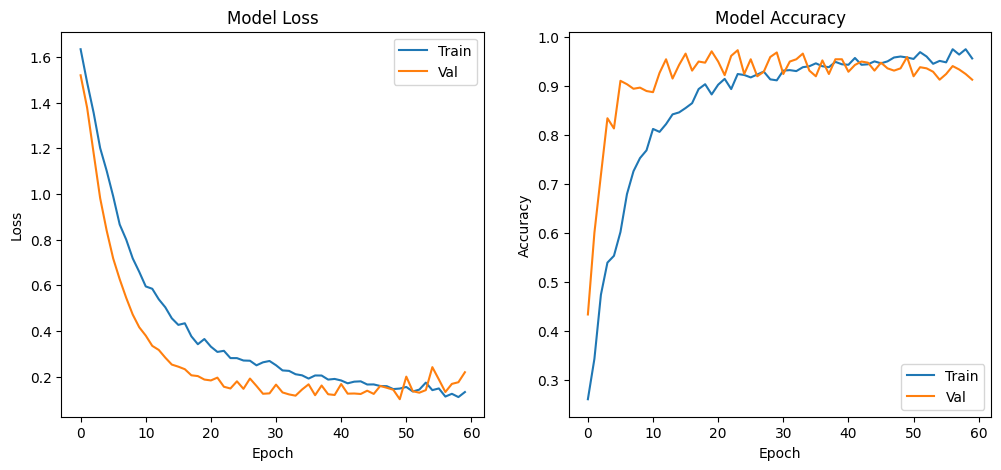

In [20]:
plot_model_metrics(trained_model_dropout)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
[[88  0  0  0  0]
 [ 0 98  0  0  0]
 [ 0  4 53  0 34]
 [ 0  0  0 83  0]
 [ 0  0  0  0 72]]


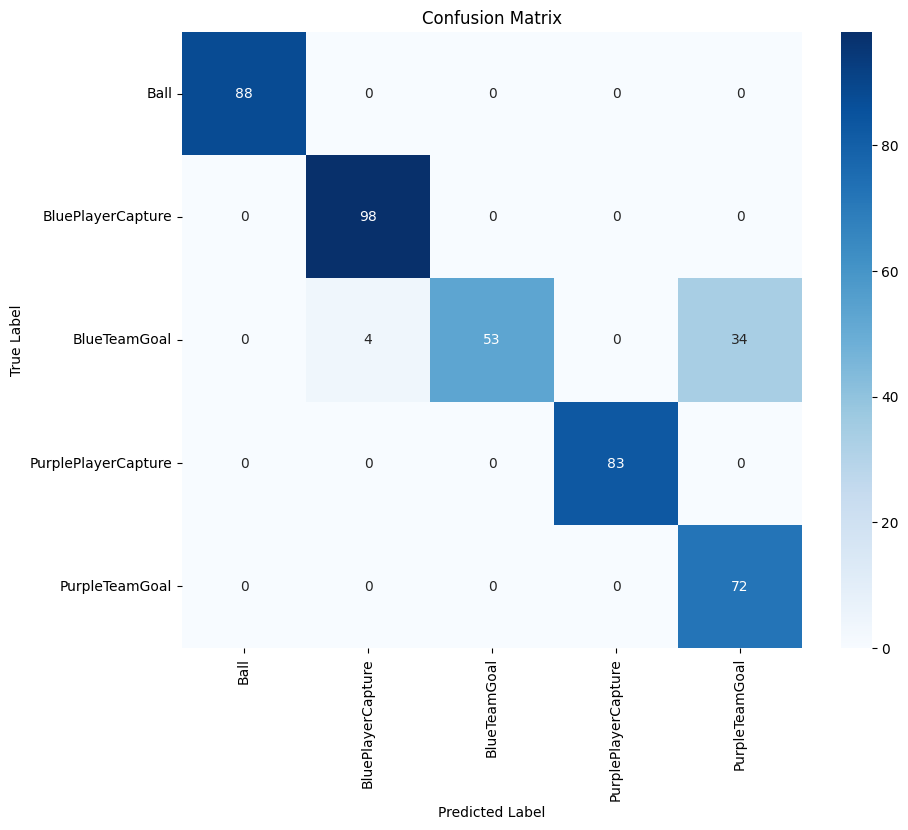

In [21]:
test_labels = test_generator.classes

# Predict the probabilities on the test data
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_classes)

print(cm)

# Plot the confusion matrix
plot_confusion_matrix(cm, test_generator)

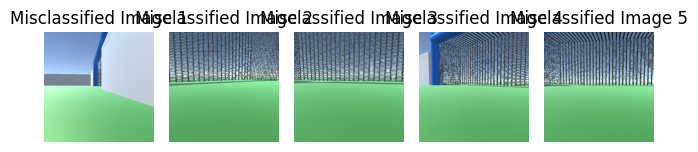

In [22]:
misclassified_indices = np.where(test_labels != predicted_classes)[0]
if misclassified_indices.size > 0:
    plot_mismatched_images(image_dir, test_df, misclassified_indices)
else:
    print("No misclassified images found.")